In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [28]:
#import required package
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import math
from scipy import signal
from scipy import ndimage
from scipy import spatial
from pprint import pprint
from PIL import Image
from osgeo import gdal

In [29]:
#set the address where the numpy array containing the results of the IBG classifier are
resultsNumpyAddress="G:/0002FE75/frs0002fe75_01_if168l_trr3_CAT_corr_denoised_p_co3.npy"
#read the numpy array
co3Map=np.load(resultsNumpyAddress,
                allow_pickle=True,
                fix_imports=True)
del resultsNumpyAddress

In [30]:
#get map of carbontes from the numpy array
myMap=np.where(co3Map>0,1,0)
bothMap=np.where(myMap==1,myMap,np.nan)
myMap=np.where(co3Map==2,1,0)
myMap=np.where(co3Map==1,1,np.nan)

In [31]:
#set the address of the datacube to be read
headerFileAddress="G:/0002FE75/frs0002fe75_01_if168l_trr3_CAT_corr_denoised_p.hdr"
#read the datacube and its wavelength list
currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
del currentObservationImage
wavelengthList=np.array(currentObservationHeader.bands.centers)
del currentObservationHeader
del headerFileAddress

In [32]:
#set the wavelength of the last band to retain
finalBandWavelength=2.60212
#set the wavelength of the first band to retain
firstBandWavelength=1.05375
#subset the datacube
datacube=datacube[:,
                  :,
                  np.logical_and(wavelengthList<=finalBandWavelength,
                                     wavelengthList>=firstBandWavelength)]
#subset the wavelength list
wavelengthList=wavelengthList[np.logical_and(wavelengthList<=finalBandWavelength,
                                             wavelengthList>=firstBandWavelength)]

In [33]:
#identify in scene pixels and create a map where all inscene pixels are 1 and out of scene pixels are -1
imageFootprint=np.full_like(datacube[:,:,0],1)
datacube[np.where(np.isnan(datacube))]=65535.0
[rows,cols,bands]=np.shape(datacube)
for i in range(rows):
    for j in range(cols):
        temp=datacube[i,j,:]
        if np.any(temp==65535.0) or np.any(np.logical_and(temp>1,temp<0)):
            imageFootprint[i,j]=-1
datacube[np.where(np.isnan(datacube))]=65535.0

C:\Users\104D\AppData\Local\Temp/ipykernel_568/3524751460.py:23: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  bothMap=ndimage.morphology.binary_dilation(bothMap,


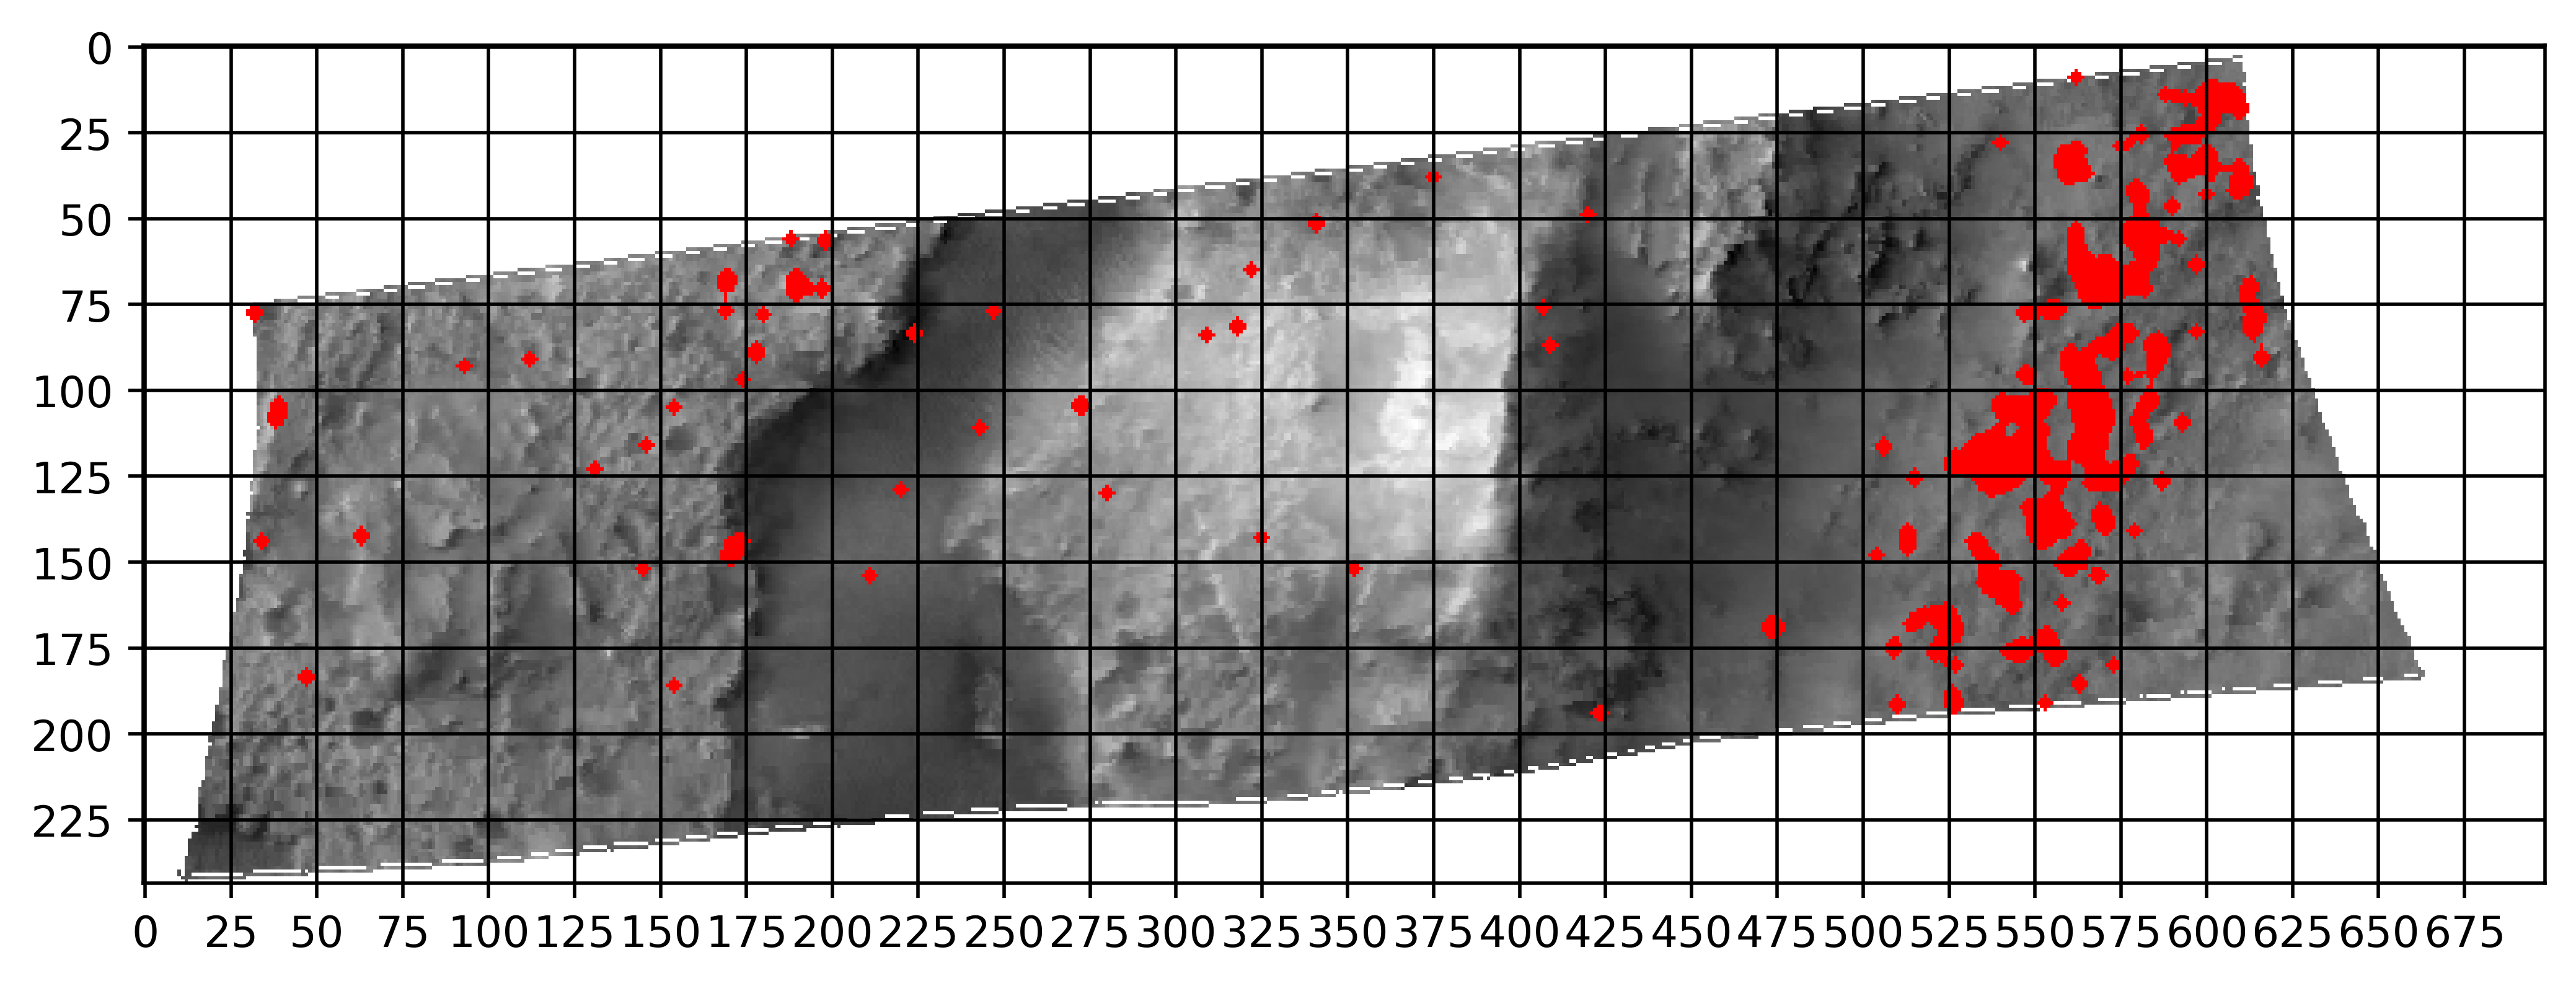

In [41]:
setFontsize=10
baseSize=10
plt.figure(figsize=(baseSize*datacube.shape[0]/datacube.shape[0],
                    baseSize),
           dpi=500)

plt.yticks(np.arange(0,
                     datacube.shape[0],
                     25),
           fontsize=setFontsize,
           visible=True)

plt.xticks(np.arange(0,
                     datacube.shape[1],
                     25),
           fontsize=setFontsize,
           visible=True)

#plt.axis('off')
#plt.box(False)

bothMap=np.where(co3Map>0,1,0)
bothMap=ndimage.morphology.binary_dilation(bothMap,
                                           structure=np.ones((5,5)).astype(bothMap.dtype),
                                           iterations=1)
bothMap=ndimage.median_filter(bothMap,
                              size=5)


maps=[]
for i in [13,13,13]:
    singleBand=datacube[:,:,i]
    singleBand=(singleBand-np.amin(singleBand[imageFootprint==1]))/np.ptp(singleBand[imageFootprint==1])
    singleBand[imageFootprint==-1]=np.amax(singleBand[imageFootprint==1])
    maps.append(singleBand)
grayScaleImage=np.dstack((maps))

plt.imshow(grayScaleImage)


overlay=np.where(bothMap!=1,
                 np.nan,
                 1)

overlay[0,0]=0

plt.imshow(overlay[:,:],
           cmap='rainbow')

plt.grid(visible=True,
         color='black')

C:\Users\104D\AppData\Local\Temp/ipykernel_568/3860527305.py:23: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  bothMap=ndimage.morphology.binary_dilation(bothMap,


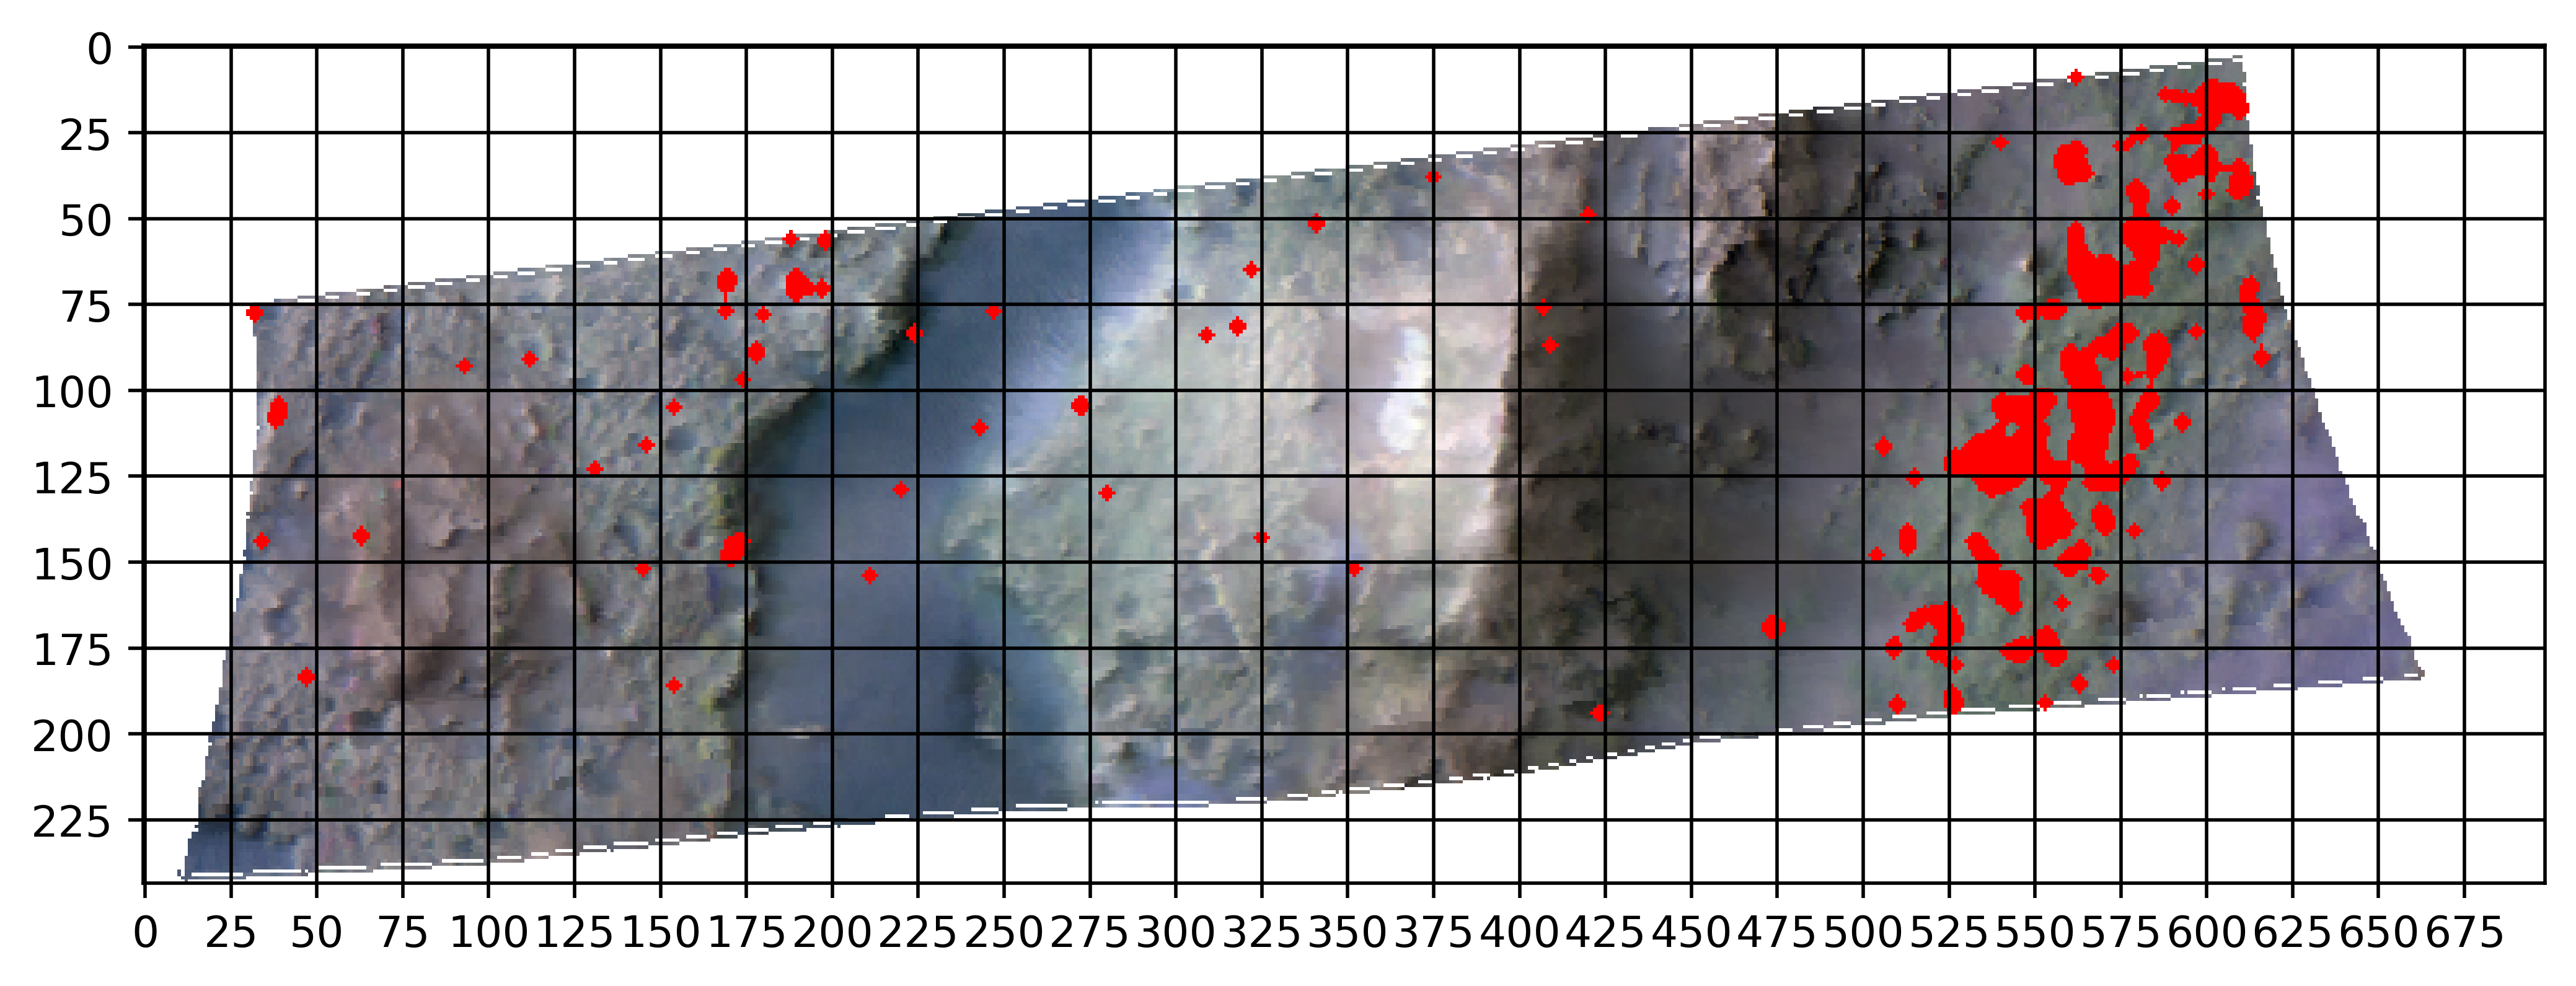

In [42]:
setFontsize=10
baseSize=10
plt.figure(figsize=(baseSize*datacube.shape[0]/datacube.shape[0],
                    baseSize),
           dpi=500)

plt.yticks(np.arange(0,
                     datacube.shape[0],
                     25),
           fontsize=setFontsize,
           visible=True)

plt.xticks(np.arange(0,
                     datacube.shape[1],
                     25),
           fontsize=setFontsize,
           visible=True)

#plt.axis('off')
#plt.box(False)

bothMap=np.where(co3Map>0,1,0)
bothMap=ndimage.morphology.binary_dilation(bothMap,
                                           structure=np.ones((5,5)).astype(bothMap.dtype),
                                           iterations=1)
bothMap=ndimage.median_filter(bothMap,
                              size=5)


maps=[]
for i in [13,78,233]:
    singleBand=datacube[:,:,i]
    singleBand=(singleBand-np.amin(singleBand[imageFootprint==1]))/np.ptp(singleBand[imageFootprint==1])
    singleBand[imageFootprint==-1]=np.amax(singleBand[imageFootprint==1])
    maps.append(singleBand)
grayScaleImage=np.dstack((maps))

plt.imshow(grayScaleImage)


overlay=np.where(bothMap!=1,
                 np.nan,
                 1)

overlay[0,0]=0

plt.imshow(overlay[:,:],
           cmap='rainbow')

plt.grid(visible=True,
         color='black')